# Sovereign Debt Sentiment Analysis
### IMF Article IV Summary Tone Measurement Notebook

In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

from tqdm.auto import tqdm

## Load Data

**What this does (high level)**  
Loads the URAP sovereign-debt **manifest file** containing metadata and extracted information about the IMF Article IV documents. This will be the base dataframe we run sentiment analysis on.

**How it does it**  
- Uses `pandas.read_csv` to load the `manifest` CSV stored in the `data/` subfolder of the URAP repo.  
- Stores it in a dataframe called `df_manifest`.  
- Prints the shape to see how many rows and columns there are.  
- Shows the first few rows so we can verify that key columns (like country, year, summary text, URLs, etc.) are present and correctly parsed.


In [3]:
# Path to the manifest CSV relative to the notebook location
DATA_PATH = "data/manifest.csv"  # change if your filename is manifest_final.csv, etc.

# Load the manifest into a DataFrame
df_manifest = pd.read_csv(DATA_PATH)

# Basic structural info
print("Shape of manifest dataframe:", df_manifest.shape)
df_manifest.head()

Shape of manifest dataframe: (143, 18)


,iso2,iso3,country,year,imf_url,press_release_url,status,title,pdf_path,text_path,first_snippet,notes,eba_text_path,eba_snippet,eba_status,summary_path,summary_snippet,summary_status
0,DJ,DJI,Djibouti,2025,https://www.imf.org/en/publications/cr/issues/...,https://www.imf.org/en/news/articles/2025/09/1...,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted
1,MX,MEX,Mexico,2025,https://www.imf.org/en/publications/cr/issues/...,https://www.imf.org/en/news/articles/2025/10/2...,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted
2,US,USA,United States,2024,https://www.imf.org/en/publications/cr/issues/...,NaN,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted
3,DO,DOM,Dominican Republic,2024,https://www.imf.org/en/publications/cr/issues/...,NaN,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted
4,NI,NIC,Nicaragua,2023,https://www.imf.org/en/publications/cr/issues/...,NaN,pending,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted


## Exploratory Data Analysis (EDA)

**What this does at a high level**  
We explore the structure and quality of the manifest dataset — including missing summaries, text lengths, country-year coverage, and duplicates — to ensure it is ready for sentiment analysis.

**How it does it**  
- Computes missing values across all fields  
- Examines summary availability (`summary_extracted` vs `summary_missing`)  
- Measures summary lengths to anticipate chunking for BERT  
- Checks country and year coverage  
- Identifies short or problematic summaries  
- Displays a few random samples for qualitative inspection  

In [6]:
# step  1 drop unnecessary columns 
df = df_manifest.drop(['press_release_url', 'status', 'title', 'pdf_path', 'text_path', 'first_snippet', 'notes', 'eba_text_path', 'eba_snippet', 'eba_status'], axis=1)

In [7]:
df

,iso2,iso3,country,year,imf_url,summary_path,summary_snippet,summary_status
0,DJ,DJI,Djibouti,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted
1,MX,MEX,Mexico,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted
2,US,USA,United States,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted
3,DO,DOM,Dominican Republic,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted
4,NI,NIC,Nicaragua,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted
...,...,...,...,...,...,...,...,...
138,GA,GAB,Gabon,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\GA\2025_summary.txt,The 2024 Article IV Consultation discusses tha...,summary_extracted
139,MT,MLT,Malta,2024,https://www.imf.org/en/publications/cr/issues/...,NaN,NaN,summary_missing
140,HK,HKG,Hong Kong SAR,2024,https://www.imf.org/en/publications/cr/issues/...,NaN,NaN,summary_missing
141,LA,LAO,Lao People's Democratic Republic,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\LA\2023_summary.txt,This 2023 Article IV Consultation discusses th...,summary_extracted


In [9]:
# Uses `isnull().mean()` to compute the percentage of missing values in each column.
df.isnull().mean().sort_values(ascending=False)

summary_path       0.090909
summary_snippet    0.090909
iso2               0.006993
imf_url            0.006993
iso3               0.000000
country            0.000000
year               0.000000
summary_status     0.000000
dtype: float64

In [11]:
# Summary Availability: Counts values in the `source` (or similar) column that indicates `summary_extracted` or `summary_missing`.
df["summary_status"].value_counts(dropna=False)

summary_status
summary_extracted    130
summary_missing       12
summary_error          1
Name: count, dtype: int64

In [20]:
df = df[df["summary_status"] == 'summary_extracted']
df

,iso2,iso3,country,year,imf_url,summary_path,summary_snippet,summary_status
0,DJ,DJI,Djibouti,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted
1,MX,MEX,Mexico,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted
2,US,USA,United States,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted
3,DO,DOM,Dominican Republic,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted
4,NI,NIC,Nicaragua,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted
...,...,...,...,...,...,...,...,...
136,NE,NER,Niger,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\NE\2025_summary.txt,This paper presents Niger’s 2024 Article IV co...,summary_extracted
137,BF,BFA,Burkina Faso,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\BF\2024_summary.txt,This paper focuses on Burkina Faso’s 2024 Arti...,summary_extracted
138,GA,GAB,Gabon,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\GA\2025_summary.txt,The 2024 Article IV Consultation discusses tha...,summary_extracted
141,LA,LAO,Lao People's Democratic Republic,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\LA\2023_summary.txt,This 2023 Article IV Consultation discusses th...,summary_extracted


In [21]:
# Summary Length Distribution: Computes word counts in each summary and plots a histogram.

SUMMARY_COL = "summary_snippet"  # adjust if needed

summary_lengths = (
    df[SUMMARY_COL]
    .fillna("")
    .astype(str)
    .apply(lambda x: len(x.split()))
)

summary_lengths.describe()

count    130.000000
mean     147.461538
std       39.258861
min       51.000000
25%      125.250000
50%      160.000000
75%      176.000000
max      210.000000
Name: summary_snippet, dtype: float64

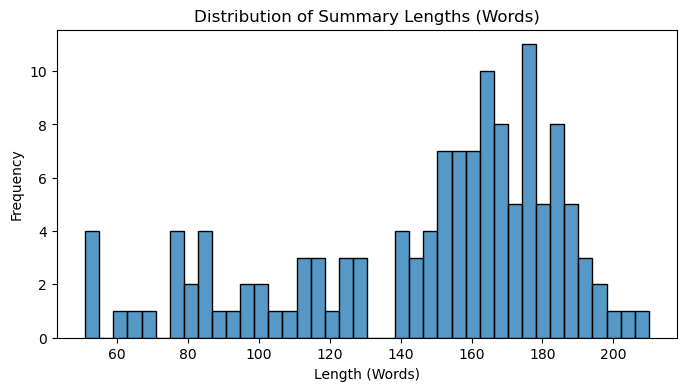

In [22]:
plt.figure(figsize=(8, 4))
sns.histplot(summary_lengths, bins=40)
plt.title("Distribution of Summary Lengths (Words)")
plt.xlabel("Length (Words)")
plt.ylabel("Frequency")
plt.show()

In [24]:
# Country Coverage: Counts observations grouped by the ISO3-country field.
df["iso3"].value_counts()


iso3
JOR    2
DJI    1
PAN    1
AGO    1
SEN    1
      ..
JPN    1
STP    1
MNG    1
TON    1
LAO    1
Name: count, Length: 129, dtype: int64

In [29]:
df[df["iso3"] == "JOR"]
df.drop(index=95, inplace=True)

KeyError: '[95] not found in axis'

In [30]:
df

,iso2,iso3,country,year,imf_url,summary_path,summary_snippet,summary_status
0,DJ,DJI,Djibouti,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted
1,MX,MEX,Mexico,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted
2,US,USA,United States,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted
3,DO,DOM,Dominican Republic,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted
4,NI,NIC,Nicaragua,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted
...,...,...,...,...,...,...,...,...
136,NE,NER,Niger,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\NE\2025_summary.txt,This paper presents Niger’s 2024 Article IV co...,summary_extracted
137,BF,BFA,Burkina Faso,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\BF\2024_summary.txt,This paper focuses on Burkina Faso’s 2024 Arti...,summary_extracted
138,GA,GAB,Gabon,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\GA\2025_summary.txt,The 2024 Article IV Consultation discusses tha...,summary_extracted
141,LA,LAO,Lao People's Democratic Republic,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\LA\2023_summary.txt,This 2023 Article IV Consultation discusses th...,summary_extracted


In [18]:
# Year Coverage: Counts occurrences of each year in ascending order.
df_manifest["year"].value_counts().sort_index()

year
2020     1
2021     1
2022     4
2023    19
2024    60
2025    58
Name: count, dtype: int64

## Cleaning Summaries for Sentiment Analysis

**What this does at a high level**  
Creates a unified text-cleaning pipeline that prepares the IMF Article IV summaries for three different sentiment tools: FinBERT, VADER, and FinVADER. The goal is to standardize the text while preserving financial terminology and sentiment cues.

**How it does it**  
- Removes escape characters, extra whitespace, and formatting artifacts  
- Normalizes spacing around punctuation  
- Removes non-UTF characters that can break lexicons  
- Preserves financial language, sentence structure, and punctuation  
- Produces a cleaned column called `summary_cleaned`  

In [31]:
import re
import unicodedata

In [32]:
def clean_summary_text(text: str) -> str:
    """
    Clean summary text for FinBERT, VADER, and FinVADER.

    Key principles:
    - Preserve punctuation and casing for sentiment signals.
    - Normalize whitespace.
    - Remove control characters & odd unicode.
    """

    # Handle missing values
    if not isinstance(text, str):
        return ""

    # Normalize unicode characters
    text = unicodedata.normalize("NFKC", text)

    # Remove weird control chars (ASCII control blocks)
    text = re.sub(r"[\x00-\x1F\x7F-\x9F]", " ", text)

    # Replace tabs/newlines with spaces
    text = text.replace("\n", " ").replace("\t", " ")

    # Collapse multiple spaces into one
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [33]:
# apply the clean_text function to the dataset
df["summary_cleaned"] = (
    df[SUMMARY_COL]
    .fillna("")
    .apply(clean_summary_text)
)

In [34]:
df

,iso2,iso3,country,year,imf_url,summary_path,summary_snippet,summary_status,summary_cleaned
0,DJ,DJI,Djibouti,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted,Djibouti's investment-focused strategy has pro...
1,MX,MEX,Mexico,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted,Economic activity has been soft since mid-2024...
2,US,USA,United States,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted,The 2024 Article IV Consultation highlights th...
3,DO,DOM,Dominican Republic,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted,The 2024 Article IV Consultation explains that...
4,NI,NIC,Nicaragua,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted,The 2023 Article IV Consultation highlights th...
...,...,...,...,...,...,...,...,...,...
136,NE,NER,Niger,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\NE\2025_summary.txt,This paper presents Niger’s 2024 Article IV co...,summary_extracted,This paper presents Niger’s 2024 Article IV co...
137,BF,BFA,Burkina Faso,2024,https://www.imf.org/en/publications/cr/issues/...,data\text\BF\2024_summary.txt,This paper focuses on Burkina Faso’s 2024 Arti...,summary_extracted,This paper focuses on Burkina Faso’s 2024 Arti...
138,GA,GAB,Gabon,2025,https://www.imf.org/en/publications/cr/issues/...,data\text\GA\2025_summary.txt,The 2024 Article IV Consultation discusses tha...,summary_extracted,The 2024 Article IV Consultation discusses tha...
141,LA,LAO,Lao People's Democratic Republic,2023,https://www.imf.org/en/publications/cr/issues/...,data\text\LA\2023_summary.txt,This 2023 Article IV Consultation discusses th...,summary_extracted,This 2023 Article IV Consultation discusses th...


In [39]:
c = df["summary_cleaned"][0]

In [40]:
o = df["summary_snippet"][0]

In [41]:
print(c == o)

False


## Sentiment Analysis Models: FinBERT, VADER, FinVADER

**What this does at a high level**  
Runs three different sentiment analysis models on cleaned IMF Article IV summaries:

1. **FinBERT** — transformer model trained on financial text  
2. **VADER** — lexicon-based sentiment tool for general English  
3. **FinVADER** — domain-specific version of VADER tuned for finance  

Using all three provides robustness and allows later comparison of tone patterns across models.

**How it does it**  
- Loads each sentiment model  
- Defines helper functions to run inference on a single cleaned summary  
- Applies each model to the `summary_cleaned` column  
- Stores results in new sentiment feature columns  

### FinBERT Numerical Sentiment Score (0 to 1)

**What this does at a high level**  
Uses FinBERT's 3-class financial sentiment output (negative, neutral, positive) to create a single continuous sentiment score between 0 and 1, where 0 is fully negative, 0.5 is neutral, and 1 is fully positive.

**How it does it**  
- Runs FinBERT to get probabilities for negative, neutral, and positive.  
- Computes an expected sentiment on the scale [-1, 1]:  
  - E = P(positive) − P(negative)  
- Maps this to [0, 1] via:  
  - score = (E + 1) / 2  
- Stores both:
  - `finbert_score` (0–1)  
  - the raw probabilities (optional, for debugging/advanced analysis).

In [43]:
def finbert_sentiment(text: str):
    """
    Run FinBERT on cleaned text and return:
    - finbert_score: continuous sentiment in [0, 1]
        0   -> fully negative
        0.5 -> neutral
        1   -> fully positive
    - plus raw probabilities for inspection.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {
            "finbert_score": np.nan,
            "finbert_pos": np.nan,
            "finbert_neu": np.nan,
            "finbert_neg": np.nan,
            "finbert_label": None,
        }

    inputs = finbert_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).to(device)

    with torch.no_grad():
        outputs = finbert_model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    # unpack probabilities
    p_pos = float(probs[0])
    p_neu = float(probs[1])
    p_neg = float(probs[2])

    # label by argmax (still useful to have)
    label = FINBERT_LABELS[int(np.argmax(probs))]

    # expected sentiment E in [-1, 1]
    # E = P(pos) - P(neg)
    E = p_pos - p_neg

    # map from [-1, 1] to [0, 1]
    finbert_score = (E + 1.0) / 2.0

    return {
        "finbert_score": finbert_score,
        "finbert_pos": p_pos,
        "finbert_neu": p_neu,
        "finbert_neg": p_neg,
        "finbert_label": label,
    }

In [44]:
tqdm.pandas()

finbert_results = df["summary_cleaned"].progress_apply(finbert_sentiment)
finbert_df = pd.DataFrame(finbert_results.tolist())

df_sentiment = pd.concat([df_manifest, finbert_df], axis=1)
df_sentiment.head()

  0%|          | 0/129 [00:00<?, ?it/s]

,iso2,iso3,country,year,imf_url,press_release_url,status,title,pdf_path,text_path,...,eba_snippet,eba_status,summary_path,summary_snippet,summary_status,finbert_score,finbert_pos,finbert_neu,finbert_neg,finbert_label
0,DJ,DJI,Djibouti,2025,https://www.imf.org/en/publications/cr/issues/...,https://www.imf.org/en/news/articles/2025/09/1...,pending,NaN,NaN,NaN,...,NaN,NaN,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted,0.933795,0.896150,0.075290,0.028560,positive
1,MX,MEX,Mexico,2025,https://www.imf.org/en/publications/cr/issues/...,https://www.imf.org/en/news/articles/2025/10/2...,pending,NaN,NaN,NaN,...,NaN,NaN,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted,0.497518,0.015577,0.963883,0.020540,neutral
2,US,USA,United States,2024,https://www.imf.org/en/publications/cr/issues/...,NaN,pending,NaN,NaN,NaN,...,NaN,NaN,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted,0.611025,0.248697,0.724656,0.026647,neutral
3,DO,DOM,Dominican Republic,2024,https://www.imf.org/en/publications/cr/issues/...,NaN,pending,NaN,NaN,NaN,...,NaN,NaN,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted,0.923068,0.917931,0.010275,0.071794,positive
4,NI,NIC,Nicaragua,2023,https://www.imf.org/en/publications/cr/issues/...,NaN,pending,NaN,NaN,NaN,...,NaN,NaN,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted,0.952462,0.937495,0.029933,0.032572,positive


### VADER Numerical Sentiment Score (0 to 1)

**What this does at a high level**  
Computes a sentiment score using the VADER lexicon-based model and converts its `compound` score (−1 to +1) into a normalized value in [0, 1].

**How it does it**  
- Runs VADER to get neg/neu/pos/compound  
- Maps compound → [0, 1] using:  
  score = (compound + 1) / 2  
- Returns:
  - `vader_score` (0→negative, 0.5→neutral, 1→positive)
  - original VADER outputs for inspection

In [46]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

def vader_sentiment(text: str):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {
            "vader_score": np.nan,
            "vader_neg": np.nan,
            "vader_neu": np.nan,
            "vader_pos": np.nan,
            "vader_compound": np.nan
        }

    scores = vader.polarity_scores(text)
    compound = scores["compound"]

    # map [-1, 1] → [0, 1]
    vader_score = (compound + 1) / 2

    return {
        "vader_score": vader_score,
        "vader_neg": scores["neg"],
        "vader_neu": scores["neu"],
        "vader_pos": scores["pos"],
        "vader_compound": compound,
    }

### FinVADER Numerical Sentiment Score (0 to 1)

**What this does at a high level**  
Enhances VADER with domain-specific financial terms and computes the same 0–1 sentiment score for IMF text.

**How it does it**  
- Extends VADER’s lexicon with financial sentiment words  
- Runs `.polarity_scores()`  
- Converts compound → [0, 1]  

In [48]:
finvader = SentimentIntensityAnalyzer()

financial_lexicon = {
    "default": -2.0,
    "restructuring": -1.5,
    "refinancing": -0.8,
    "liquidity": -0.4,
    "downgrade": -2.0,
    "upgrade": 1.4,
    "fiscal consolidation": -0.6,
    "macroeconomic stability": 1.2,
    "strong fundamentals": 1.5,
    "debt distress": -2.5,
}

finvader.lexicon.update(financial_lexicon)

In [49]:
def finvader_sentiment(text: str):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {
            "finvader_score": np.nan,
            "finv_neg": np.nan,
            "finv_neu": np.nan,
            "finv_pos": np.nan,
            "finv_compound": np.nan
        }

    scores = finvader.polarity_scores(text)
    compound = scores["compound"]

    # convert [-1, 1] → [0, 1]
    finvader_score = (compound + 1) / 2

    return {
        "finvader_score": finvader_score,
        "finv_neg": scores["neg"],
        "finv_neu": scores["neu"],
        "finv_pos": scores["pos"],
        "finv_compound": compound,
    }

In [51]:
finbert_results = df["summary_cleaned"].progress_apply(finbert_sentiment)
vader_results = df["summary_cleaned"].progress_apply(vader_sentiment)
finvader_results = df["summary_cleaned"].progress_apply(finvader_sentiment)

finbert_df = pd.DataFrame(finbert_results.tolist())
vader_df   = pd.DataFrame(vader_results.tolist())
finvader_df = pd.DataFrame(finvader_results.tolist())

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

In [53]:
df_sentiment = pd.concat(
    [df, finbert_df, vader_df, finvader_df],
    axis=1
)

df_sentiment.head()

,iso2,iso3,country,year,imf_url,summary_path,summary_snippet,summary_status,summary_cleaned,finbert_score,...,vader_score,vader_neg,vader_neu,vader_pos,vader_compound,finvader_score,finv_neg,finv_neu,finv_pos,finv_compound
0,DJ,DJI,Djibouti,2025.0,https://www.imf.org/en/publications/cr/issues/...,data\text\DJ\2025_summary.txt,Djibouti's investment-focused strategy has pro...,summary_extracted,Djibouti's investment-focused strategy has pro...,0.933795,...,0.82430,0.141,0.680,0.179,0.6486,0.82430,0.141,0.680,0.179,0.6486
1,MX,MEX,Mexico,2025.0,https://www.imf.org/en/publications/cr/issues/...,data\text\MX\2025_summary.txt,Economic activity has been soft since mid-2024...,summary_extracted,Economic activity has been soft since mid-2024...,0.497518,...,0.17280,0.143,0.825,0.032,-0.6544,0.17280,0.143,0.825,0.032,-0.6544
2,US,USA,United States,2024.0,https://www.imf.org/en/publications/cr/issues/...,data\text\US\2024_summary.txt,The 2024 Article IV Consultation highlights th...,summary_extracted,The 2024 Article IV Consultation highlights th...,0.611025,...,0.97240,0.047,0.824,0.129,0.9448,0.97240,0.047,0.824,0.129,0.9448
3,DO,DOM,Dominican Republic,2024.0,https://www.imf.org/en/publications/cr/issues/...,data\text\DO\2024_summary.txt,The 2024 Article IV Consultation explains that...,summary_extracted,The 2024 Article IV Consultation explains that...,0.923068,...,0.99195,0.029,0.777,0.194,0.9839,0.99195,0.029,0.777,0.194,0.9839
4,NI,NIC,Nicaragua,2023.0,https://www.imf.org/en/publications/cr/issues/...,data\text\NI\2023_summary.txt,The 2023 Article IV Consultation highlights th...,summary_extracted,The 2023 Article IV Consultation highlights th...,0.952462,...,0.62580,0.100,0.795,0.105,0.2516,0.62580,0.100,0.795,0.105,0.2516
